In [1]:
import os
import re
import pdfplumber
import pandas as pd


In [2]:
# Base folder
base_folder = r"C:\Users\User\DengueRisk\Dengue_cases_2022-2025"

# Year folders inside the base folder
year_folders = ['Dengue_cases_2022', 'Dengue_cases_2023', 'Dengue_cases_2024', 'Dengue_cases_2025']

# List of districts
districts_list = [
    "Colombo", "Gampaha", "Kalutara", "Kandy", "Matale", "Nuwara Eliya",
    "Galle", "Hambantota", "Matara", "Jaffna", "Kilinochchi", "Mannar",
    "Vavuniya", "Mullaitivu", "Batticaloa", "Ampara", "Trincomalee",
    "Kalmunai", "Kurunegala", "Puttalam", "Anuradhapura", "Polonnaruwa",
    "Badulla", "Monaragala", "Ratnapura", "Kegalle"
]

# Regex to extract week number from filename
week_pattern = re.compile(r"[Ww]eek[ _-]*(\d{1,2})|[Ww](\d{1,2})|wk[ _-]*(\d{1,2})")

all_data = []

for year_folder in year_folders:
    folder_path = os.path.join(base_folder, year_folder)
    print(f"Processing folder: {folder_path}")

    # Extract year number from folder name
    year_match = re.search(r"20\d{2}", year_folder)
    year = int(year_match.group()) if year_match else None

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(".pdf"):
            pdf_path = os.path.join(folder_path, filename)

            # Extract week from filename
            week = None
            wk_match = week_pattern.search(filename)
            if wk_match:
                week = next((int(g) for g in wk_match.groups() if g), None)

            # Combine year and week into a single string
            year_week = f"{year}_W{week:02d}" if week else f"{year}"

            # Extract text from PDF
            with pdfplumber.open(pdf_path) as pdf:
                full_text = ""
                for page in pdf.pages:
                    text = page.extract_text()
                    if text:
                        full_text += " " + text
            full_text = re.sub(r"\s+", " ", full_text)

            # Regex to find districts and 6 case numbers
            pattern = re.compile(
                rf"({'|'.join(districts_list)})\s+(\d+|Nil)\s+(\d+|Nil)\s+(\d+|Nil)\s+(\d+|Nil)\s+(\d+|Nil)\s+(\d+|Nil)",
                re.IGNORECASE
            )

            for match in pattern.finditer(full_text):
                district = match.group(1)
                week_cases_str = match.group(5)  # Adjust column if needed
                week_cases = 0 if week_cases_str.lower() == "nil" else int(week_cases_str)

                all_data.append([year_week, district, week_cases])

# Create DataFrame in memory
df_dengue = pd.DataFrame(
    all_data,
    columns=["Year_Week", "District", "Cases"]
)

print("✅ Dengue DataFrame ready in memory")
df_dengue.head()


Processing folder: C:\Users\User\DengueRisk\Dengue_cases_2022-2025\Dengue_cases_2022
Processing folder: C:\Users\User\DengueRisk\Dengue_cases_2022-2025\Dengue_cases_2023
Processing folder: C:\Users\User\DengueRisk\Dengue_cases_2022-2025\Dengue_cases_2024
Processing folder: C:\Users\User\DengueRisk\Dengue_cases_2022-2025\Dengue_cases_2025
✅ Dengue DataFrame ready in memory


,Year_Week,District,Cases
0,2022_W01,Colombo,563
1,2022_W01,Gampaha,457
2,2022_W01,Kalutara,180
3,2022_W01,Kandy,89
4,2022_W01,Matale,20


In [3]:
# Fill missing weeks with 0 (or could use NaN if you prefer)
df_dengue['Week'] = df_dengue['Year_Week'].str.extract(r'_W(\d+)$')[0]  # extract week from Year_Week
df_dengue['Week'] = df_dengue['Week'].fillna(0).astype(int)

# Preview
print("✅ Missing weeks handled")
df_dengue.head()


✅ Missing weeks handled


,Year_Week,District,Cases,Week
0,2022_W01,Colombo,563,1
1,2022_W01,Gampaha,457,1
2,2022_W01,Kalutara,180,1
3,2022_W01,Kandy,89,1
4,2022_W01,Matale,20,1


In [4]:
from datetime import date
import pandas as pd

def get_week_start(row):
    try:
        if row['Week'] == 0:
            return pd.NaT
        # ISO calendar: Monday=1
        year = int(row['Year_Week'].split('_')[0])
        return date.fromisocalendar(year, row['Week'], 1)
    except Exception:
        return pd.NaT

df_dengue['WeekStartDate'] = df_dengue.apply(get_week_start, axis=1)

# Preview
print("✅ Week start dates calculated")
df_dengue.head()


✅ Week start dates calculated


,Year_Week,District,Cases,Week,WeekStartDate
0,2022_W01,Colombo,563,1,2022-01-03
1,2022_W01,Gampaha,457,1,2022-01-03
2,2022_W01,Kalutara,180,1,2022-01-03
3,2022_W01,Kandy,89,1,2022-01-03
4,2022_W01,Matale,20,1,2022-01-03


In [5]:
# Sort by Year_Week, then District alphabetically
df_dengue = df_dengue.sort_values(by=['Year_Week', 'District']).reset_index(drop=True)

# Preview
print("✅ DataFrame sorted")
df_dengue.head()


✅ DataFrame sorted


,Year_Week,District,Cases,Week,WeekStartDate
0,2022_W01,Ampara,8,1,2022-01-03
1,2022_W01,Anuradhapura,12,1,2022-01-03
2,2022_W01,Badulla,64,1,2022-01-03
3,2022_W01,Batticaloa,26,1,2022-01-03
4,2022_W01,Colombo,563,1,2022-01-03


In [6]:
# Base folder containing weather CSVs
weather_folder = r"C:\Users\User\DengueRisk\Weather_2022-2025"

# List of districts
districts_list = [
    "Colombo", "Gampaha", "Kalutara", "Kandy", "Matale", "Nuwara Eliya",
    "Galle", "Hambantota", "Matara", "Jaffna", "Kilinochchi", "Mannar",
    "Vavuniya", "Mullaitivu", "Batticaloa", "Ampara", "Trincomalee",
    "Kalmunai", "Kurunegala", "Puttalam", "Anuradhapura", "Polonnaruwa",
    "Badulla", "Monaragala", "Ratnapura", "Kegalle"
]

# Preview the files in the folder
print("Files in weather folder:")
for f in os.listdir(weather_folder):
    print(f"  '{f}'")

Files in weather folder:
  'Ampara.csv'
  'Anuradhapura.csv'
  'Badulla.csv'
  'Batticaloa.csv'
  'Colombo.csv'
  'Galle.csv'
  'Gampaha.csv'
  'Hambantota.csv'
  'Jaffna.csv'
  'Kalmunai.csv'
  'Kalutara.csv'
  'Kandy.csv'
  'Kegalle.csv'
  'Kilinochchi.csv'
  'Kurunegala.csv'
  'Mannar.csv'
  'Matale.csv'
  'Matara.csv'
  'Monaragala.csv'
  'Mullaitivu.csv'
  'Nuwara Eliya.csv'
  'Polonnaruwa.csv'
  'Puttalam.csv'
  'Ratnapura.csv'
  'Trincomalee.csv'
  'Vavuniya.csv'


In [7]:
all_dfs = []

for district in districts_list:
    file_path = os.path.join(weather_folder, f"{district}.csv")
    print(f"Checking file for district '{district}': {file_path}")
    
    if not os.path.exists(file_path):
        print(f"Warning: Weather file for {district} not found, skipping.")
        continue
    
    # Read CSV and parse 'time' column as datetime
    df = pd.read_csv(file_path, parse_dates=['time'], dayfirst=True, encoding='utf-8')
    
    # Add a column for district
    df['district'] = district
    
    all_dfs.append(df)
    
    # Preview first 3 rows of this district's data
    print(f"Preview for {district}:")
    display(df.head(3))


Checking file for district 'Colombo': C:\Users\User\DengueRisk\Weather_2022-2025\Colombo.csv
Preview for Colombo:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,25.7,30.3,22.6,3.5,3.5,37617.29,42220.21,11.6,3.85,Colombo
1,2022-01-02,26.2,30.8,23.2,8.0,8.0,38743.27,42225.70,14.6,4.11,Colombo
2,2022-01-03,25.7,31.6,23.4,14.2,14.2,31520.95,42231.66,15.9,3.80,Colombo


Checking file for district 'Gampaha': C:\Users\User\DengueRisk\Weather_2022-2025\Gampaha.csv
Preview for Gampaha:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,25.7,31.4,22.5,7.3,7.3,37238.61,42191.26,13.9,3.57,Gampaha
1,2022-01-02,26.2,30.6,23.1,4.5,4.5,38742.48,42196.86,15.0,3.94,Gampaha
2,2022-01-03,25.8,31.2,23.4,11.9,11.9,31565.54,42202.95,16.5,3.90,Gampaha


Checking file for district 'Kalutara': C:\Users\User\DengueRisk\Weather_2022-2025\Kalutara.csv
Preview for Kalutara:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,25.4,29.4,21.3,0.0,0.0,38832.52,42292.54,11.6,4.28,Kalutara
1,2022-01-02,25.7,29.9,22.2,1.5,1.5,37944.25,42297.72,11.7,3.88,Kalutara
2,2022-01-03,25.2,29.6,22.8,6.7,6.7,30134.25,42303.37,8.5,3.66,Kalutara


Checking file for district 'Kandy': C:\Users\User\DengueRisk\Weather_2022-2025\Kandy.csv
Preview for Kandy:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,23.3,26.5,21.4,0.5,0.5,38901.88,42147.79,20.5,3.52,Kandy
1,2022-01-02,23.2,26.7,21.3,0.7,0.7,34823.41,42153.58,20.2,3.29,Kandy
2,2022-01-03,23.1,26.9,21.4,5.6,5.6,32813.89,42159.86,21.3,3.22,Kandy


Checking file for district 'Matale': C:\Users\User\DengueRisk\Weather_2022-2025\Matale.csv
Preview for Matale:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,24.4,28.4,21.3,4.7,4.7,38855.23,42104.29,14.6,3.79,Matale
1,2022-01-02,24.1,27.8,21.8,2.2,2.2,34003.77,42110.25,17.1,3.49,Matale
2,2022-01-03,23.9,28.1,21.9,2.5,2.5,33565.27,42116.73,17.3,3.24,Matale


Checking file for district 'Nuwara Eliya': C:\Users\User\DengueRisk\Weather_2022-2025\Nuwara Eliya.csv
Preview for Nuwara Eliya:


,time,temperature_2m_mean (°C),temperature_2m_max (°C),temperature_2m_min (°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,15.2,18.2,12.8,1.5,1.5,38931.35,42205.74,13.7,2.70,Nuwara Eliya
1,2022-01-02,15.6,18.7,13.6,2.9,2.9,35190.02,42211.28,15.0,2.77,Nuwara Eliya
2,2022-01-03,15.2,18.0,13.9,7.1,7.1,28407.83,42217.31,15.9,2.22,Nuwara Eliya


Checking file for district 'Galle': C:\Users\User\DengueRisk\Weather_2022-2025\Galle.csv
Preview for Galle:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,24.9,28.6,22.3,9.3,9.3,37334.73,42393.63,10.7,3.51,Galle
1,2022-01-02,25.4,29.6,22.8,2.1,2.1,35382.02,42398.41,17.2,3.48,Galle
2,2022-01-03,25.1,29.2,22.8,6.2,6.2,26513.71,42403.60,8.5,3.25,Galle


Checking file for district 'Hambantota': C:\Users\User\DengueRisk\Weather_2022-2025\Hambantota.csv
Preview for Hambantota:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,26.8,31.0,24.1,1.8,1.8,39141.93,42379.20,21.9,4.57,Hambantota
1,2022-01-02,26.8,31.2,24.0,0.3,0.3,39118.10,42384.04,24.7,5.03,Hambantota
2,2022-01-03,26.6,31.1,24.1,0.8,0.8,38115.48,42389.29,24.4,4.66,Hambantota


Checking file for district 'Matara': C:\Users\User\DengueRisk\Weather_2022-2025\Matara.csv
Preview for Matara:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,26.2,29.1,24.3,2.2,2.2,39025.59,42422.48,20.6,4.09,Matara
1,2022-01-02,26.6,29.2,24.7,2.8,2.8,36335.58,42427.14,23.2,4.36,Matara
2,2022-01-03,26.3,29.2,24.9,2.0,2.0,34760.62,42432.21,20.6,3.96,Matara


Checking file for district 'Jaffna': C:\Users\User\DengueRisk\Weather_2022-2025\Jaffna.csv
Preview for Jaffna:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,24.5,26.6,23.4,13.9,13.9,31347.03,41652.26,20.1,2.53,Jaffna
1,2022-01-02,24.9,27.0,22.6,6.6,6.6,23861.51,41660.07,23.1,2.51,Jaffna
2,2022-01-03,25.9,27.6,24.7,0.5,0.5,38457.96,41668.56,25.2,3.83,Jaffna


Checking file for district 'Kilinochchi': C:\Users\User\DengueRisk\Weather_2022-2025\Kilinochchi.csv
Preview for Kilinochchi:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,24.2,26.2,22.5,29.4,29.4,32247.38,41710.87,18.9,2.59,Kilinochchi
1,2022-01-02,24.4,27.0,23.1,4.7,4.7,13510.35,41718.44,20.6,2.08,Kilinochchi
2,2022-01-03,25.7,27.4,24.1,1.6,1.6,38568.31,41726.67,24.3,3.47,Kilinochchi


Checking file for district 'Mannar': C:\Users\User\DengueRisk\Weather_2022-2025\Mannar.csv
Preview for Mannar:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,25.1,28.3,23.2,3.1,3.1,38374.12,41798.62,24.2,3.08,Mannar
1,2022-01-02,25.0,27.7,23.4,1.2,1.2,19185.25,41805.83,21.9,2.50,Mannar
2,2022-01-03,26.0,28.6,23.6,0.3,0.3,31860.74,41813.67,25.3,3.53,Mannar


Checking file for district 'Vavuniya': C:\Users\User\DengueRisk\Weather_2022-2025\Vavuniya.csv
Preview for Vavuniya:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,23.8,26.7,22.0,7.9,7.9,25024.68,41842.42,19.0,2.42,Vavuniya
1,2022-01-02,23.6,25.8,22.5,5.4,5.4,18000.00,41849.45,17.6,1.80,Vavuniya
2,2022-01-03,24.3,26.9,22.5,4.7,4.7,34167.31,41857.10,20.6,2.81,Vavuniya


Checking file for district 'Mullaitivu': C:\Users\User\DengueRisk\Weather_2022-2025\Mullaitivu.csv
Preview for Mullaitivu:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,24.6,25.9,23.4,27.4,27.4,29700.95,41740.14,18.3,2.45,Mullaitivu
1,2022-01-02,24.8,25.7,23.4,12.3,12.3,11550.19,41747.59,21.5,2.00,Mullaitivu
2,2022-01-03,26.1,27.5,24.9,3.5,3.5,31743.43,41755.69,23.7,3.66,Mullaitivu


Checking file for district 'Batticaloa': C:\Users\User\DengueRisk\Weather_2022-2025\Batticaloa.csv
Preview for Batticaloa:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,24.6,26.9,22.9,17.3,17.3,32332.60,42060.75,20.4,2.69,Batticaloa
1,2022-01-02,24.5,26.5,23.2,20.6,20.6,17776.02,42066.89,19.8,2.14,Batticaloa
2,2022-01-03,24.7,27.1,23.5,24.9,24.9,24832.57,42073.57,19.9,2.56,Batticaloa


Checking file for district 'Ampara': C:\Users\User\DengueRisk\Weather_2022-2025\Ampara.csv
Preview for Ampara:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,24.2,27.7,22.1,8.8,8.8,30749.66,42147.79,16.2,2.88,Ampara
1,2022-01-02,24.1,27.5,22.7,10.2,10.2,23970.31,42153.58,14.3,2.45,Ampara
2,2022-01-03,23.9,27.6,21.7,17.8,17.8,22517.95,42159.86,14.8,2.55,Ampara


Checking file for district 'Trincomalee': C:\Users\User\DengueRisk\Weather_2022-2025\Trincomalee.csv
Preview for Trincomalee:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,24.2,26.0,22.7,30.7,30.7,26487.94,41886.18,16.5,2.24,Trincomalee
1,2022-01-02,24.5,26.4,22.6,14.1,14.1,27739.14,41893.03,17.1,2.26,Trincomalee
2,2022-01-03,24.5,26.9,22.6,18.3,18.3,30035.19,41900.48,18.9,2.50,Trincomalee


Checking file for district 'Kalmunai': C:\Users\User\DengueRisk\Weather_2022-2025\Kalmunai.csv
Preview for Kalmunai:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,24.8,26.7,23.4,23.5,23.5,28760.55,42118.80,17.4,2.74,Kalmunai
1,2022-01-02,24.9,26.5,23.5,14.4,14.4,30445.95,42124.70,19.3,2.63,Kalmunai
2,2022-01-03,24.9,26.7,23.6,20.4,20.4,21287.20,42131.11,18.1,2.56,Kalmunai


Checking file for district 'Kurunegala': C:\Users\User\DengueRisk\Weather_2022-2025\Kurunegala.csv
Preview for Kurunegala:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,25.5,29.9,22.8,2.2,2.2,38818.56,42104.29,17.1,4.00,Kurunegala
1,2022-01-02,25.2,28.5,22.9,2.1,2.1,37004.17,42110.25,20.3,3.68,Kurunegala
2,2022-01-03,25.1,29.6,23.2,1.6,1.6,35104.79,42116.73,20.5,3.70,Kurunegala


Checking file for district 'Puttalam': C:\Users\User\DengueRisk\Weather_2022-2025\Puttalam.csv
Preview for Puttalam:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,25.4,29.7,23.5,5.2,5.2,32200.74,41988.10,18.9,3.25,Puttalam
1,2022-01-02,25.4,28.3,23.6,3.1,3.1,32400.00,41994.53,20.9,3.00,Puttalam
2,2022-01-03,25.0,28.5,23.3,17.2,17.2,38559.51,42001.53,20.0,2.95,Puttalam


Checking file for district 'Anuradhapura': C:\Users\User\DengueRisk\Weather_2022-2025\Anuradhapura.csv
Preview for Anuradhapura:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,24.2,28.7,21.6,8.7,8.7,24309.56,41929.89,20.3,2.70,Anuradhapura
1,2022-01-02,24.0,26.8,22.7,3.3,3.3,17754.42,41936.56,18.4,1.91,Anuradhapura
2,2022-01-03,24.1,27.1,22.5,8.2,8.2,34647.20,41943.81,20.4,2.57,Anuradhapura


Checking file for district 'Polonnaruwa': C:\Users\User\DengueRisk\Weather_2022-2025\Polonnaruwa.csv
Preview for Polonnaruwa:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,24.2,27.9,22.4,17.0,17.0,24835.10,42017.18,15.1,2.39,Polonnaruwa
1,2022-01-02,23.6,25.1,22.6,10.7,10.7,2234.91,42023.49,12.5,1.40,Polonnaruwa
2,2022-01-03,23.9,27.1,22.3,30.1,30.1,15508.47,42030.36,14.8,2.16,Polonnaruwa


Checking file for district 'Badulla': C:\Users\User\DengueRisk\Weather_2022-2025\Badulla.csv
Preview for Badulla:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,21.5,24.0,20.6,8.6,8.6,32400.00,42205.74,8.8,2.56,Badulla
1,2022-01-02,21.4,24.7,20.3,6.9,6.9,23567.48,42211.28,9.8,2.39,Badulla
2,2022-01-03,21.2,23.7,20.0,19.9,19.9,22537.69,42217.31,9.5,2.12,Badulla


Checking file for district 'Monaragala': C:\Users\User\DengueRisk\Weather_2022-2025\Monaragala.csv
Preview for Monaragala:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,24.7,28.2,22.3,2.3,2.3,36256.20,42234.69,17.0,3.26,Monaragala
1,2022-01-02,24.5,28.2,22.6,2.0,2.0,33716.38,42240.11,17.2,3.31,Monaragala
2,2022-01-03,24.1,28.0,22.3,9.0,9.0,27462.74,42246.01,19.1,3.10,Monaragala


Checking file for district 'Ratnapura': C:\Users\User\DengueRisk\Weather_2022-2025\Ratnapura.csv
Preview for Ratnapura:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,25.1,30.2,21.3,14.7,14.7,35286.20,42263.61,6.2,4.01,Ratnapura
1,2022-01-02,25.4,29.5,21.4,7.5,7.5,30260.14,42268.93,7.9,3.53,Ratnapura
2,2022-01-03,25.0,29.4,22.1,27.1,27.1,28040.18,42274.70,7.4,3.42,Ratnapura


Checking file for district 'Kegalle': C:\Users\User\DengueRisk\Weather_2022-2025\Kegalle.csv
Preview for Kegalle:


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district
0,2022-01-01,25.2,29.8,21.9,5.8,5.8,38847.01,42147.79,14.0,3.98,Kegalle
1,2022-01-02,25.3,30.0,22.3,1.1,1.1,38296.59,42153.58,14.7,3.96,Kegalle
2,2022-01-03,24.7,29.8,22.4,7.6,7.6,38305.09,42159.86,16.4,3.67,Kegalle


In [8]:
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print("✅ All district weather data combined into a single DataFrame.")
    
    # Preview first 5 rows of combined data
    combined_df.head()
else:
    print("⚠️ No files were combined. Check file paths and availability.")


✅ All district weather data combined into a single DataFrame.


In [9]:
from datetime import date

# Ensure 'time' is datetime
combined_df['time'] = pd.to_datetime(combined_df['time'], dayfirst=True)

# Extract ISO year and week
combined_df['year'] = combined_df['time'].dt.isocalendar().year
combined_df['week'] = combined_df['time'].dt.isocalendar().week

print("✅ ISO year and week extracted")
combined_df.head()



✅ ISO year and week extracted


,time,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),district,temperature_2m_mean (°C),temperature_2m_max (°C),temperature_2m_min (°C),year,week
0,2022-01-01,25.7,30.3,22.6,3.5,3.5,37617.29,42220.21,11.6,3.85,Colombo,NaN,NaN,NaN,2021,52
1,2022-01-02,26.2,30.8,23.2,8.0,8.0,38743.27,42225.70,14.6,4.11,Colombo,NaN,NaN,NaN,2021,52
2,2022-01-03,25.7,31.6,23.4,14.2,14.2,31520.95,42231.66,15.9,3.80,Colombo,NaN,NaN,NaN,2022,1
3,2022-01-04,26.3,30.8,23.3,4.0,4.0,36323.74,42238.17,22.6,4.45,Colombo,NaN,NaN,NaN,2022,1
4,2022-01-05,25.8,29.8,23.5,3.0,3.0,30000.44,42245.24,19.8,3.91,Colombo,NaN,NaN,NaN,2022,1


In [10]:
# Aggregate weekly per district
weekly_df = combined_df.groupby(['district', 'year', 'week']).agg({
    'temperature_2m_mean (Â°C)': 'mean',
    'temperature_2m_max (Â°C)': 'max',
    'temperature_2m_min (Â°C)': 'min',
    'precipitation_sum (mm)': 'sum',
    'rain_sum (mm)': 'sum',
    'sunshine_duration (s)': 'sum',
    'daylight_duration (s)': 'sum',
    'wind_speed_10m_max (km/h)': 'max',
    'et0_fao_evapotranspiration (mm)': 'sum'
}).reset_index()

print("✅ Weather data aggregated weekly")
weekly_df.head()


✅ Weather data aggregated weekly


,district,year,week,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm)
0,Ampara,2021,52,24.150000,27.7,22.1,19.0,19.0,54719.97,84301.37,16.2,5.33
1,Ampara,2022,1,24.485714,28.9,21.7,50.8,50.8,206686.56,295282.97,21.4,19.92
2,Ampara,2022,2,25.157143,30.1,22.0,33.1,33.1,238056.72,295774.93,15.1,22.92
3,Ampara,2022,3,24.385714,30.5,18.2,5.4,5.4,273206.15,296413.43,17.1,31.03
4,Ampara,2022,4,24.700000,30.1,19.0,5.1,5.1,271425.78,297174.91,15.7,29.24


In [11]:
# Add Monday date for each week
weekly_df['week_start_date'] = weekly_df.apply(
    lambda row: date.fromisocalendar(row['year'], row['week'], 1), axis=1
)

print("✅ Week start dates added")
weekly_df.head()


✅ Week start dates added


,district,year,week,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),week_start_date
0,Ampara,2021,52,24.150000,27.7,22.1,19.0,19.0,54719.97,84301.37,16.2,5.33,2021-12-27
1,Ampara,2022,1,24.485714,28.9,21.7,50.8,50.8,206686.56,295282.97,21.4,19.92,2022-01-03
2,Ampara,2022,2,25.157143,30.1,22.0,33.1,33.1,238056.72,295774.93,15.1,22.92,2022-01-10
3,Ampara,2022,3,24.385714,30.5,18.2,5.4,5.4,273206.15,296413.43,17.1,31.03,2022-01-17
4,Ampara,2022,4,24.700000,30.1,19.0,5.1,5.1,271425.78,297174.91,15.7,29.24,2022-01-24


In [12]:
# Sort by district, year, week
weekly_df = weekly_df.sort_values(by=['district', 'year', 'week']).reset_index(drop=True)

print("✅ Weekly weather data sorted")
weekly_df.head()


✅ Weekly weather data sorted


,district,year,week,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),week_start_date
0,Ampara,2021,52,24.150000,27.7,22.1,19.0,19.0,54719.97,84301.37,16.2,5.33,2021-12-27
1,Ampara,2022,1,24.485714,28.9,21.7,50.8,50.8,206686.56,295282.97,21.4,19.92,2022-01-03
2,Ampara,2022,2,25.157143,30.1,22.0,33.1,33.1,238056.72,295774.93,15.1,22.92,2022-01-10
3,Ampara,2022,3,24.385714,30.5,18.2,5.4,5.4,273206.15,296413.43,17.1,31.03,2022-01-17
4,Ampara,2022,4,24.700000,30.1,19.0,5.1,5.1,271425.78,297174.91,15.7,29.24,2022-01-24


In [13]:
# 1️⃣ Ensure 'week_start_date' is datetime
weekly_df['week_start_date'] = pd.to_datetime(weekly_df['week_start_date'])
print("✅ 'week_start_date' converted to datetime")
weekly_df.head()

#Optional: Convert district to categorical for consistent sorting
sorted_districts = sorted(weekly_df['district'].unique())
weekly_df['district'] = pd.Categorical(weekly_df['district'], categories=sorted_districts, ordered=True)
print("✅ Districts converted to categorical (alphabetical order)")
weekly_df.head()

# Filter by cutoff date (e.g., 16-June-2025)
cutoff_date = pd.to_datetime('2025-06-16')
weekly_df = weekly_df[weekly_df['week_start_date'] <= cutoff_date].reset_index(drop=True)
print(f"✅ Data filtered to include only weeks <= {cutoff_date.date()}")
weekly_df.head()

# 5️⃣ Sort by district and week_start_date
weekly_df = weekly_df.sort_values(by=['district', 'week_start_date']).reset_index(drop=True)
print("✅ Data sorted by district and week_start_date")
weekly_df.head()




✅ 'week_start_date' converted to datetime
✅ Districts converted to categorical (alphabetical order)
✅ Data filtered to include only weeks <= 2025-06-16
✅ Data sorted by district and week_start_date


,district,year,week,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),week_start_date
0,Ampara,2021,52,24.150000,27.7,22.1,19.0,19.0,54719.97,84301.37,16.2,5.33,2021-12-27
1,Ampara,2022,1,24.485714,28.9,21.7,50.8,50.8,206686.56,295282.97,21.4,19.92,2022-01-03
2,Ampara,2022,2,25.157143,30.1,22.0,33.1,33.1,238056.72,295774.93,15.1,22.92,2022-01-10
3,Ampara,2022,3,24.385714,30.5,18.2,5.4,5.4,273206.15,296413.43,17.1,31.03,2022-01-17
4,Ampara,2022,4,24.700000,30.1,19.0,5.1,5.1,271425.78,297174.91,15.7,29.24,2022-01-24


In [14]:
# Normalize district names in both DataFrames
df_dengue['District'] = df_dengue['District'].str.strip().str.lower()
weekly_df['district'] = weekly_df['district'].str.strip().str.lower()

print("✅ District names normalized (stripped and lowercase)")
print("Dengue preview:")
display(df_dengue.head())
print("Weather preview:")
display(weekly_df.head())



✅ District names normalized (stripped and lowercase)
Dengue preview:


,Year_Week,District,Cases,Week,WeekStartDate
0,2022_W01,ampara,8,1,2022-01-03
1,2022_W01,anuradhapura,12,1,2022-01-03
2,2022_W01,badulla,64,1,2022-01-03
3,2022_W01,batticaloa,26,1,2022-01-03
4,2022_W01,colombo,563,1,2022-01-03


Weather preview:


,district,year,week,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),week_start_date
0,ampara,2021,52,24.150000,27.7,22.1,19.0,19.0,54719.97,84301.37,16.2,5.33,2021-12-27
1,ampara,2022,1,24.485714,28.9,21.7,50.8,50.8,206686.56,295282.97,21.4,19.92,2022-01-03
2,ampara,2022,2,25.157143,30.1,22.0,33.1,33.1,238056.72,295774.93,15.1,22.92,2022-01-10
3,ampara,2022,3,24.385714,30.5,18.2,5.4,5.4,273206.15,296413.43,17.1,31.03,2022-01-17
4,ampara,2022,4,24.700000,30.1,19.0,5.1,5.1,271425.78,297174.91,15.7,29.24,2022-01-24


In [15]:
# Ensure WeekStartDate is datetime
df_dengue['WeekStartDate'] = pd.to_datetime(df_dengue['WeekStartDate'])
weekly_df['week_start_date'] = pd.to_datetime(weekly_df['week_start_date'])

print("✅ WeekStartDate columns converted to datetime")
display(df_dengue.head())
display(weekly_df.head())


✅ WeekStartDate columns converted to datetime


,Year_Week,District,Cases,Week,WeekStartDate
0,2022_W01,ampara,8,1,2022-01-03
1,2022_W01,anuradhapura,12,1,2022-01-03
2,2022_W01,badulla,64,1,2022-01-03
3,2022_W01,batticaloa,26,1,2022-01-03
4,2022_W01,colombo,563,1,2022-01-03


,district,year,week,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm),week_start_date
0,ampara,2021,52,24.150000,27.7,22.1,19.0,19.0,54719.97,84301.37,16.2,5.33,2021-12-27
1,ampara,2022,1,24.485714,28.9,21.7,50.8,50.8,206686.56,295282.97,21.4,19.92,2022-01-03
2,ampara,2022,2,25.157143,30.1,22.0,33.1,33.1,238056.72,295774.93,15.1,22.92,2022-01-10
3,ampara,2022,3,24.385714,30.5,18.2,5.4,5.4,273206.15,296413.43,17.1,31.03,2022-01-17
4,ampara,2022,4,24.700000,30.1,19.0,5.1,5.1,271425.78,297174.91,15.7,29.24,2022-01-24


In [16]:
# Merge on district and week start date
combined_df = pd.merge(
    df_dengue,
    weekly_df,
    left_on=['District', 'WeekStartDate'],
    right_on=['district', 'week_start_date'],
    how='left'  # keep all dengue rows
)

# Drop duplicate district columns from weather
combined_df = combined_df.drop(columns=['district', 'week_start_date'], errors='ignore')

print("✅ Dengue and weather data merged")
display(combined_df.head())


✅ Dengue and weather data merged


,Year_Week,District,Cases,Week,WeekStartDate,year,week,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm)
0,2022_W01,ampara,8,1,2022-01-03,2022,1,24.485714,28.9,21.7,50.8,50.8,206686.56,295282.97,21.4,19.92
1,2022_W01,anuradhapura,12,1,2022-01-03,2022,1,24.971429,29.9,21.9,14.1,14.1,255617.67,293795.87,20.4,24.22
2,2022_W01,badulla,64,1,2022-01-03,2022,1,21.100000,24.9,18.0,78.1,78.1,179577.35,295678.42,14.5,16.71
3,2022_W01,batticaloa,26,1,2022-01-03,2022,1,25.314286,28.2,23.1,67.1,67.1,237101.87,294688.95,23.6,21.62
4,2022_W01,colombo,563,1,2022-01-03,2022,1,26.214286,32.0,22.8,27.9,27.9,245154.69,295777.20,22.6,29.46


In [17]:
# Round all float columns to 3 decimal places for clarity
numeric_cols = combined_df.select_dtypes(include=['float64', 'float32']).columns
combined_df[numeric_cols] = combined_df[numeric_cols].round(3)

print("✅ Numeric columns rounded to 3 decimals")
display(combined_df.head())


✅ Numeric columns rounded to 3 decimals


,Year_Week,District,Cases,Week,WeekStartDate,year,week,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm)
0,2022_W01,ampara,8,1,2022-01-03,2022,1,24.486,28.9,21.7,50.8,50.8,206686.56,295282.97,21.4,19.92
1,2022_W01,anuradhapura,12,1,2022-01-03,2022,1,24.971,29.9,21.9,14.1,14.1,255617.67,293795.87,20.4,24.22
2,2022_W01,badulla,64,1,2022-01-03,2022,1,21.100,24.9,18.0,78.1,78.1,179577.35,295678.42,14.5,16.71
3,2022_W01,batticaloa,26,1,2022-01-03,2022,1,25.314,28.2,23.1,67.1,67.1,237101.87,294688.95,23.6,21.62
4,2022_W01,colombo,563,1,2022-01-03,2022,1,26.214,32.0,22.8,27.9,27.9,245154.69,295777.20,22.6,29.46


In [18]:
# Optional: move YearWeek to first column if it exists
cols = combined_df.columns.tolist()
if 'YearWeek' in cols:
    cols.insert(0, cols.pop(cols.index('YearWeek')))

# Make WeekStartDate, District, WeekEndDate the next columns
for c in ['WeekStartDate', 'District', 'WeekEndDate']:
    if c in cols:
        cols.insert(1, cols.pop(cols.index(c)))

combined_df = combined_df[cols]

print("✅ Columns reordered")
display(combined_df.head())


✅ Columns reordered


,Year_Week,District,WeekStartDate,Cases,Week,year,week,temperature_2m_mean (Â°C),temperature_2m_max (Â°C),temperature_2m_min (Â°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm)
0,2022_W01,ampara,2022-01-03,8,1,2022,1,24.486,28.9,21.7,50.8,50.8,206686.56,295282.97,21.4,19.92
1,2022_W01,anuradhapura,2022-01-03,12,1,2022,1,24.971,29.9,21.9,14.1,14.1,255617.67,293795.87,20.4,24.22
2,2022_W01,badulla,2022-01-03,64,1,2022,1,21.100,24.9,18.0,78.1,78.1,179577.35,295678.42,14.5,16.71
3,2022_W01,batticaloa,2022-01-03,26,1,2022,1,25.314,28.2,23.1,67.1,67.1,237101.87,294688.95,23.6,21.62
4,2022_W01,colombo,2022-01-03,563,1,2022,1,26.214,32.0,22.8,27.9,27.9,245154.69,295777.20,22.6,29.46


In [19]:
# Save the combined DataFrame to CSV if desired
combined_df.to_csv("DengueRiskCombinedData.csv", index=False)

In [40]:
import pandas as pd

# Load the saved file
df_check = pd.read_csv("DengueRiskCombinedData.csv")

# Count of missing values per column
print(df_check.isnull().sum())




Year_Week                            0
District                             0
WeekStartDate                        0
Cases                                0
Week                                 0
year                                 0
week                                 0
temperature_2m_mean (Â°C)          176
temperature_2m_max (Â°C)           176
temperature_2m_min (Â°C)           176
precipitation_sum (mm)               0
rain_sum (mm)                        0
sunshine_duration (s)                0
daylight_duration (s)                0
wind_speed_10m_max (km/h)            0
et0_fao_evapotranspiration (mm)      0
dtype: int64


In [20]:
import pandas as pd

# Path to the separate Nuwara Eliya weather file
nuwa_path = r"C:\Users\User\OneDrive - Sri Lanka Institute of Information Technology\Desktop\AI\DengueRisk26\Weather 2022-2025\Nuwara Eliya.csv"

# Load the CSV
nuwa_df = pd.read_csv(nuwa_path, parse_dates=['time'])  # parse 'time' if it exists

# Preview
print("✅ Nuwara Eliya weather data loaded:")
display(nuwa_df.head())


✅ Nuwara Eliya weather data loaded:


,time,temperature_2m_mean (°C),temperature_2m_max (°C),temperature_2m_min (°C),precipitation_sum (mm),rain_sum (mm),sunshine_duration (s),daylight_duration (s),wind_speed_10m_max (km/h),et0_fao_evapotranspiration (mm)
0,1/01/2022,15.2,18.2,12.8,1.5,1.5,38931.35,42205.74,13.7,2.70
1,2/01/2022,15.6,18.7,13.6,2.9,2.9,35190.02,42211.28,15.0,2.77
2,3/01/2022,15.2,18.0,13.9,7.1,7.1,28407.83,42217.31,15.9,2.22
3,4/01/2022,15.0,17.5,13.5,8.3,8.3,29842.19,42223.89,11.2,2.08
4,5/01/2022,15.1,17.3,13.2,3.7,3.7,30495.18,42231.03,9.0,2.29


In [21]:
import pandas as pd

# Load Nuwara Eliya CSV
nuwa_path = r"C:\Users\User\OneDrive - Sri Lanka Institute of Information Technology\Desktop\AI\DengueRisk26\Weather 2022-2025\Nuwara Eliya.csv"
nuwa_df = pd.read_csv(nuwa_path)

# Convert 'time' column to datetime
nuwa_df['time'] = pd.to_datetime(nuwa_df['time'], dayfirst=True, errors='coerce')  # coerce will turn invalid parsing into NaT

# Check if conversion worked
print("✅ Converted 'time' column to datetime:")
print(nuwa_df['time'].head())
print(nuwa_df['time'].dtype)



✅ Converted 'time' column to datetime:
0   2022-01-01
1   2022-01-02
2   2022-01-03
3   2022-01-04
4   2022-01-05
Name: time, dtype: datetime64[ns]
datetime64[ns]


In [22]:
import pandas as pd
from datetime import date

# Load Nuwara Eliya CSV
nuwa_path = r"C:\Users\User\OneDrive - Sri Lanka Institute of Information Technology\Desktop\AI\DengueRisk26\Weather 2022-2025\Nuwara Eliya.csv"
nuwa_df = pd.read_csv(nuwa_path)

# Convert 'time' to datetime
nuwa_df['time'] = pd.to_datetime(nuwa_df['time'], dayfirst=True, errors='coerce')

# --- Step 1: Extract ISO year and week from 'time' ---
nuwa_df['year'] = nuwa_df['time'].dt.isocalendar().year
nuwa_df['week'] = nuwa_df['time'].dt.isocalendar().week

# --- Step 2: Add WeekStartDate (Monday) ---
nuwa_df['WeekStartDate'] = nuwa_df.apply(lambda x: date.fromisocalendar(x['year'], x['week'], 1), axis=1)

# --- Step 3: Aggregate weekly temperature metrics ---
weekly_nuwa = nuwa_df.groupby('WeekStartDate').agg({
    'temperature_2m_mean (°C)': 'mean',
    'temperature_2m_max (°C)': 'max',
    'temperature_2m_min (°C)': 'min'
}).reset_index()

# Add district column
weekly_nuwa['district'] = 'nuwara eliya'

print("✅ Weekly Nuwara Eliya temperatures aggregated:")
print(weekly_nuwa.head())


✅ Weekly Nuwara Eliya temperatures aggregated:
  WeekStartDate  temperature_2m_mean (°C)  temperature_2m_max (°C)  \
0    2021-12-27                 15.400000                     18.7   
1    2022-01-03                 15.042857                     20.0   
2    2022-01-10                 15.042857                     19.9   
3    2022-01-17                 14.185714                     19.3   
4    2022-01-24                 14.242857                     21.1   

   temperature_2m_min (°C)      district  
0                     12.8  nuwara eliya  
1                      9.7  nuwara eliya  
2                     10.4  nuwara eliya  
3                      6.7  nuwara eliya  
4                      7.7  nuwara eliya  


In [23]:
print("Combined columns:", combined_df.columns.tolist())
print("Weekly Nuwara columns:", weekly_nuwa.columns.tolist())


Combined columns: ['Year_Week', 'District', 'WeekStartDate', 'Cases', 'Week', 'year', 'week', 'temperature_2m_mean (Â°C)', 'temperature_2m_max (Â°C)', 'temperature_2m_min (Â°C)', 'precipitation_sum (mm)', 'rain_sum (mm)', 'sunshine_duration (s)', 'daylight_duration (s)', 'wind_speed_10m_max (km/h)', 'et0_fao_evapotranspiration (mm)']
Weekly Nuwara columns: ['WeekStartDate', 'temperature_2m_mean (°C)', 'temperature_2m_max (°C)', 'temperature_2m_min (°C)', 'district']


In [24]:
# Ensure both columns are true datetimes
combined_df['WeekStartDate'] = pd.to_datetime(combined_df['WeekStartDate'], errors='coerce')
weekly_nuwa['WeekStartDate'] = pd.to_datetime(weekly_nuwa['WeekStartDate'], errors='coerce')


In [25]:
# Rename district column to match
weekly_nuwa_renamed = weekly_nuwa.rename(columns={'district': 'District'})

merged_df = combined_df.merge(
    weekly_nuwa_renamed,
    on=['WeekStartDate', 'District'],
    how='left',
    suffixes=('', '_nuwa')
)


In [26]:
for old_col, new_col in [
    ('temperature_2m_mean (Â°C)', 'temperature_2m_mean (°C)'),
    ('temperature_2m_max (Â°C)',  'temperature_2m_max (°C)'),
    ('temperature_2m_min (Â°C)',  'temperature_2m_min (°C)')
]:
    merged_df[old_col] = merged_df[old_col].fillna(merged_df[new_col])

# Optionally drop the extra °C columns so you’re left with one set
merged_df.drop(columns=['temperature_2m_mean (°C)',
                        'temperature_2m_max (°C)',
                        'temperature_2m_min (°C)'],
               inplace=True)

# Save
merged_df.to_csv("DengueRiskCombined_Filled.csv", index=False)
print("✅ Missing Nuwara Eliya temperatures filled and duplicate columns removed.")


✅ Missing Nuwara Eliya temperatures filled and duplicate columns removed.


In [27]:
# Save to a new file
merged_df.to_csv(
    r"C:\Users\User\OneDrive - Sri Lanka Institute of Information Technology\Desktop\AI\DengueRisk26\DengueRiskCombined_Filled.csv",
    index=False
)

print("✅ File saved as DengueRiskCombined_Filled.csv")



✅ File saved as DengueRiskCombined_Filled.csv


In [28]:
temp_cols = [
    'temperature_2m_mean (Â°C)',
    'temperature_2m_max (Â°C)',
    'temperature_2m_min (Â°C)'
]

# Round to 1 decimal place
merged_df[temp_cols] = merged_df[temp_cols].round(3)


In [29]:
print(merged_df.isna().sum())


Year_Week                          0
District                           0
WeekStartDate                      0
Cases                              0
Week                               0
year                               0
week                               0
temperature_2m_mean (Â°C)          0
temperature_2m_max (Â°C)           0
temperature_2m_min (Â°C)           0
precipitation_sum (mm)             0
rain_sum (mm)                      0
sunshine_duration (s)              0
daylight_duration (s)              0
wind_speed_10m_max (km/h)          0
et0_fao_evapotranspiration (mm)    0
dtype: int64


In [30]:
list(merged_df.columns)



['Year_Week',
 'District',
 'WeekStartDate',
 'Cases',
 'Week',
 'year',
 'week',
 'temperature_2m_mean (Â°C)',
 'temperature_2m_max (Â°C)',
 'temperature_2m_min (Â°C)',
 'precipitation_sum (mm)',
 'rain_sum (mm)',
 'sunshine_duration (s)',
 'daylight_duration (s)',
 'wind_speed_10m_max (km/h)',
 'et0_fao_evapotranspiration (mm)']

In [31]:
merged_df.drop(columns=['Week', 'year', 'week'], inplace=True)


In [32]:
# Save in the same folder as your Jupyter notebook
merged_df.to_csv("DengueRisk_data.csv", index=False)

print("✅ File saved in the Jupyter home directory as DengueRisk_data.csv")


✅ File saved in the Jupyter home directory as DengueRisk_data.csv


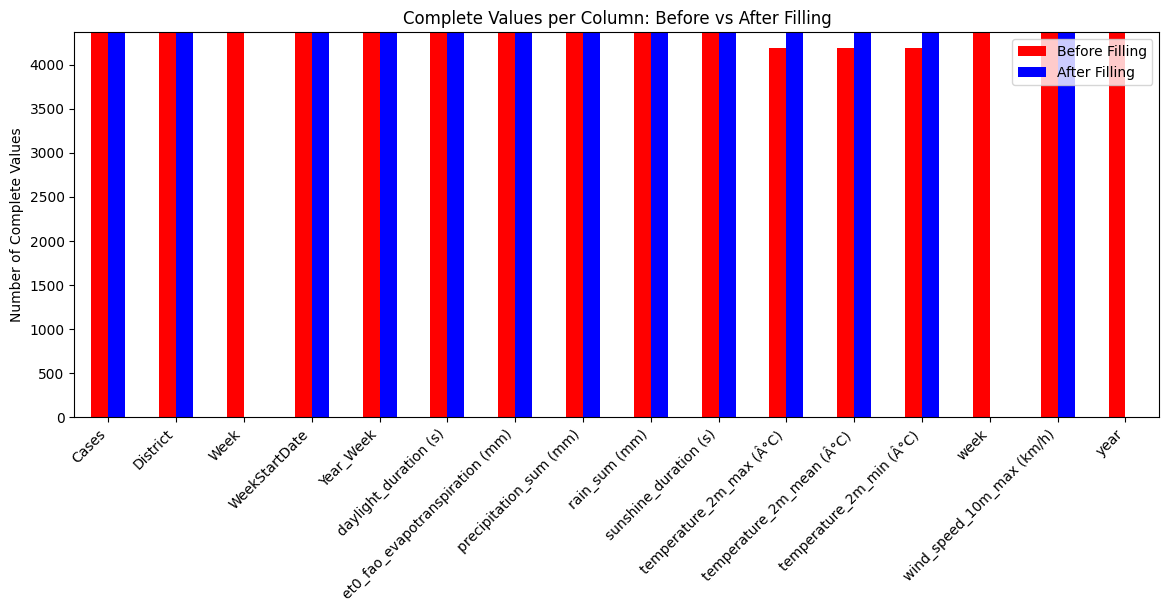

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
before_df = pd.read_csv("DengueRiskCombinedData.csv")  # before filling
after_df  = pd.read_csv("DengueRisk_data.csv")         # after filling

# Count complete rows per column
complete_before = before_df.notnull().sum()
complete_after  = after_df.notnull().sum()
total_rows = before_df.shape[0]

# Combine into one DataFrame
complete_df = pd.DataFrame({
    'Before Filling': complete_before,
    'After Filling': complete_after
})

# Plot
complete_df.plot(kind='bar', figsize=(14,5), color=['red','blue'])
plt.ylim(0, total_rows + 1)
plt.ylabel("Number of Complete Values")
plt.title("Complete Values per Column: Before vs After Filling")
plt.xticks(rotation=45, ha='right')
plt.show()
